# Estudio univariante y bivariantes de las variables explicativas del SQR

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Cargamos las librerías necesarias
from sklearn import preprocessing
from statistics import mode
from scipy import stats
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
os.chdir('..')

In [4]:
pd.options.display.max_rows = 180

In [5]:
# Cargamos datos con SQR
perfiles_sqr = pd.read_parquet('data/processed/perfiles_sqr_filtrado.parquet')
perfiles_sqr.reset_index(drop=True, inplace=True) # reseteamos el índice

In [13]:
perfiles_sqr.head()

,idSesiones,fechaInicio,fechaFin,idImatt,sqr,lecho,notaUsuario,suenios,deporte,alcohol,...,descripcion,fecha,funcion_ergonomica,altura,peso,sexo,posicion,activo,presiones,presiones_old
0,25875,2019-04-26 02:19:56,2019-04-26 09:37:05,629,83.008680,2.0,NaN,None,NaN,NaN,...,-,2019-04-25 19:41:45,1,178.0,75.0,Male,Lateral,1,122232,112222321122
1,25939,2019-04-26 23:12:10,2019-04-27 08:23:29,629,70.773244,1.0,NaN,None,NaN,NaN,...,-,2019-04-26 22:28:57,0,162.0,75.0,Female,Lateral,0,023321,002233211222
2,26043,2019-04-28 01:40:41,2019-04-28 09:31:02,348,70.144818,1.0,NaN,None,NaN,NaN,...,,2018-07-31 01:02:42,1,180.0,70.0,Male,Lateral,1,122232,112222321222
3,26044,2019-04-28 01:22:27,2019-04-28 09:24:38,348,87.152947,2.0,NaN,None,NaN,NaN,...,,2018-08-26 11:52:24,1,160.0,50.0,Female,Lateral,1,023111,002231112222
4,26076,2019-04-28 00:44:59,2019-04-28 08:39:49,629,81.126354,1.0,NaN,None,NaN,NaN,...,-,2019-04-26 22:28:57,0,162.0,75.0,Female,Lateral,0,023321,002233211222


In [21]:
sns.set_style('dark')

## Análisis univariante

##### SQR

El SQR está centrado en torno al 70-75% como refleja el siguiente histograma y sus valores de media (72.14%) y de mediana (74.26%). El valor del cuantil 9 es 50.76%, es decir, sólo un 9% de los individuos obtienen un SQR menor del 50%. El primer cuartil (25) es 63.44, lo que implica que un 75% de los usuarios logran una calidad del sueño superior al 63%.

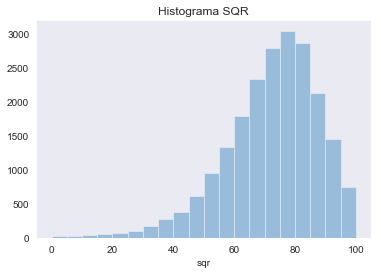

In [182]:
sns.distplot(perfiles_sqr["sqr"], bins=20,kde = False,hist=True)
plt.title("Histograma SQR")
plt.show() 

In [185]:
perfiles_sqr["sqr"].describe()

count    21219.000000
mean        72.140556
std         15.412820
min          0.018056
25%         63.448186
50%         74.257863
75%         83.089491
max         99.859722
Name: sqr, dtype: float64

In [198]:
perfiles_sqr["sqr"].quantile([0,0.08,0.09,0.1,0.2])

0.00     0.018056
0.08    49.469048
0.09    50.767978
0.10    51.989448
0.20    60.479507
Name: sqr, dtype: float64

##### Sexo

Entre los usuarios el número de hombres es ligeramente superior al de mujeres (55% vs 45%) pero está bastante equilibrado.

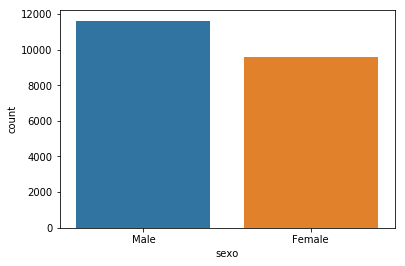

In [6]:
sns.countplot(x='sexo', data=perfiles_sqr)
plt.title("Diagrama de barras Sexo")
plt.show() 

In [188]:
perfiles_sqr["sexo"].value_counts()

Male      11617
Female     9602
Name: sexo, dtype: int64

##### Posición

El 71% de los usuarios duerme en posición lateral frente al 29% que duerme en posición supine.

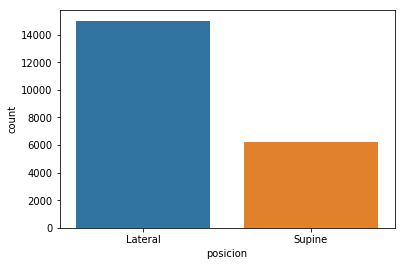

In [7]:
sns.countplot(x='posicion', data=perfiles_sqr)
plt.title("Diagrama de barras Posición"")
plt.show() 

In [189]:
perfiles_sqr["posicion"].value_counts()

Lateral    15013
Supine      6206
Name: posicion, dtype: int64

##### Altura

La altura muestra una distribución simétrica centrada en 170 cm.

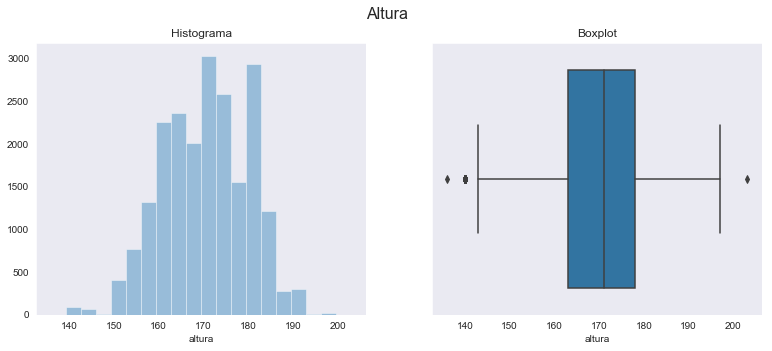

In [112]:
fig, (ax1, ax2) = plt.subplots(1,2, sharex=False, sharey=False,figsize=(13,5))
sns.distplot(perfiles_sqr["altura"], bins=20,kde = False,hist=True, ax = ax1).set_title('Histograma')
sns.boxplot(perfiles_sqr["altura"], ax = ax2).set_title('Boxplot')
fig.suptitle('Altura', fontsize=16)
plt.show()

In [32]:
perfiles_sqr["altura"].describe()

count    21219.000000
mean       170.462416
std          9.474278
min        136.000000
25%        163.000000
50%        171.000000
75%        178.000000
max        203.000000
Name: altura, dtype: float64

##### Peso

El peso medio de los usuarios es de unos 74 kg. Se encuentran algunos valores atípicos a partir de los 120 kg.

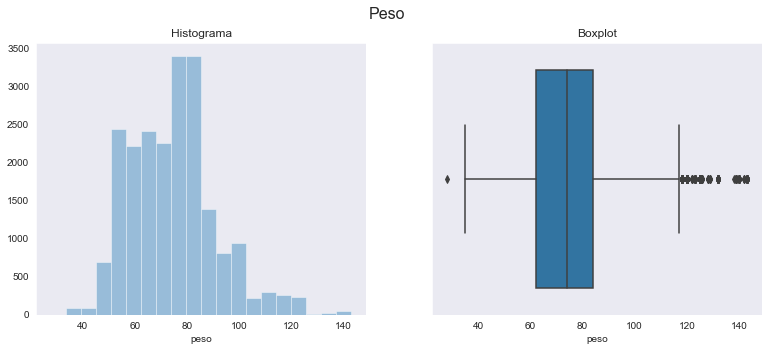

In [113]:
fig, (ax1, ax2) = plt.subplots(1,2, sharex=False, sharey=False,figsize=(13,5))
sns.distplot(perfiles_sqr["peso"], bins=20,kde = False,hist=True, ax = ax1).set_title('Histograma')
sns.boxplot(perfiles_sqr["peso"], ax = ax2).set_title('Boxplot')
fig.suptitle('Peso', fontsize=16)
plt.show()

In [33]:
perfiles_sqr["peso"].describe()

count    21219.000000
mean        74.338706
std         16.564971
min         28.000000
25%         62.000000
50%         74.000000
75%         84.000000
max        143.000000
Name: peso, dtype: float64

##### IMC

Se calcula el IMC (Índice de Masa Corporal) a partir de la altura y el peso. Se categoriza dicha variable en 3 categorías:
* Bajo peso si IMC < 25
* Normal si IMC está entre 25 y 30
* Sobrepeso si el IMC es superior a 30

In [34]:
perfiles_sqr['IMC'] = perfiles_sqr['peso'] / (perfiles_sqr['altura']/100)**2
perfiles_sqr['IMC_cat'] = pd.cut(perfiles_sqr['IMC'], bins=[0, 25, 30, 50],
                                include_lowest=True,labels=['Bajo peso', 'Normal', 'Sobrepeso'])

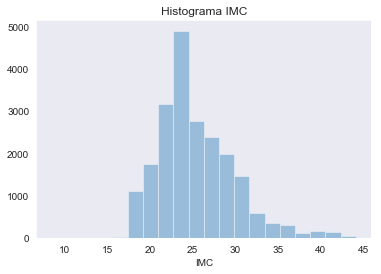

In [190]:
sns.distplot(perfiles_sqr["IMC"], bins=20,kde = False,hist=True)
plt.title("Histograma IMC")
plt.show() 

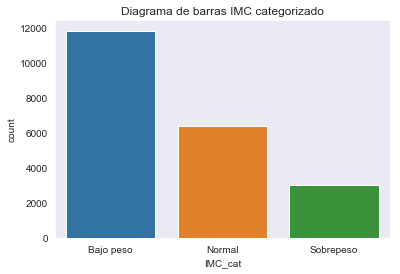

In [191]:
sns.countplot(x='IMC_cat', data=perfiles_sqr)
plt.title("Diagrama de barras IMC categorizado")
plt.show() 

In [192]:
perfiles_sqr["IMC_cat"].value_counts()

Bajo peso    11805
Normal        6393
Sobrepeso     3021
Name: IMC_cat, dtype: int64

##### Presiones

In [ ]:
# Separamos las presiones para tenerlas como 6 variables
cols = ['PresPos1', 'PresPos2', 'PresPos3', 'PresPos4', 'PresPos5', 'PresPos6']
rows = range(len(perfiles_sqr[['presiones']]))
df_pres_split = pd.DataFrame(columns=cols, index=rows)

for j in range(len(perfiles_sqr[['presiones']])):
    pres_j = perfiles_sqr.loc[j,'presiones']
    pres_j_split = [pres_j[i:i + 1] for i in range(0, len(pres_j), 1)]
    df_pres_split.iloc[j, :] = pres_j_split
# juntamos todo
perfiles_sqr = pd.concat([perfiles_sqr, df_pres_split], axis=1)

El siguiente gráfico muestra la frecuencia de uso de las 6 presiones posibles en cada uno de los 6 tubos. En el tubo 1 son más usadas las presiones bajas (0 y 1) al igual que en el tubo 6 (1 y 2) aunque en este la presión seleccionada es mayor. Por otro lado, en los tubos 2, 3, 4 y 5 las presiones más usadas son más altas (principalmente 2 y 3).

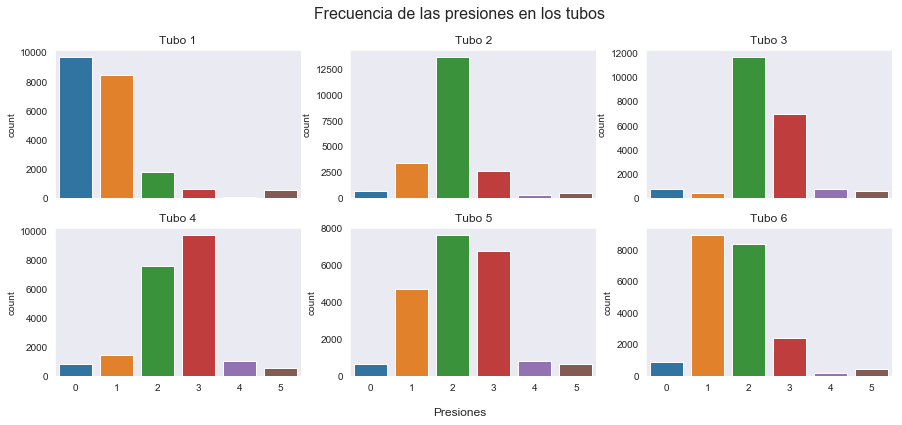

In [147]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=False,figsize = (15,6))
sns.countplot(x='PresPos1', data=perfiles_sqr,ax=axs[0, 0]).set(title = 'Tubo 1',xlabel=None)
sns.countplot(x='PresPos2', data=perfiles_sqr,ax=axs[0, 1]).set(title = 'Tubo 2',xlabel=None)
sns.countplot(x='PresPos3', data=perfiles_sqr,ax=axs[0, 2]).set(title = 'Tubo 3',xlabel=None)
sns.countplot(x='PresPos4', data=perfiles_sqr,ax=axs[1, 0]).set(title = 'Tubo 4',xlabel=None)
sns.countplot(x='PresPos5', data=perfiles_sqr,ax=axs[1, 1]).set(title = 'Tubo 5',xlabel=None)
sns.countplot(x='PresPos6', data=perfiles_sqr,ax=axs[1, 2]).set(title = 'Tubo 6',xlabel=None)
fig.text(0.5, 0.04, 'Presiones', va='center', ha='center', fontsize=12)
fig.suptitle('Frecuencia de las presiones en los tubos', fontsize=16)
plt.show()

## Análisis bivariante

#### Sexo con SQR

El SQR obtenido por las mujeres es ligeramente superior al de los hombres (media de 73 frente a 71.4).

In [98]:
perfiles_sqr.groupby('sexo').agg({'sqr': [min, max, 'mean', 'std', 'size'],})

sqr                                        
             min        max       mean        std   size
sexo                                                    
Female  0.018056  99.581944  73.031235  14.280687   9602
Male    0.548611  99.859722  71.404368  16.253099  11617

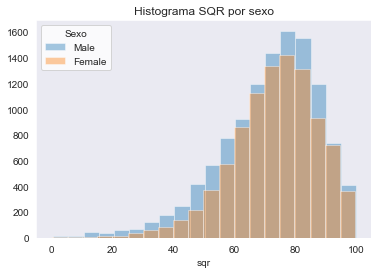

In [154]:
sns.distplot(perfiles_sqr.loc[perfiles_sqr['sexo']=="Male",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['sexo']=="Female",'sqr'], bins=20,kde = False,hist=True).set_title('Histograma SQR por sexo')
plt.legend(title='Sexo', loc='upper left', labels=['Male', 'Female'],facecolor = 'white')
plt.show()

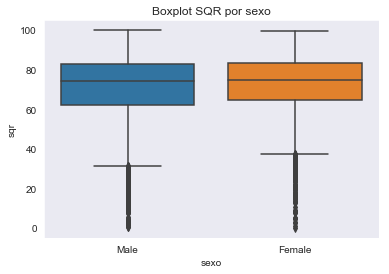

In [129]:
sns.boxplot(x="sexo", y="sqr",data=perfiles_sqr).set_title("Boxplot SQR por sexo")
plt.show()

#### Posición con SQR

In [130]:
perfiles_sqr.groupby('posicion').agg({'sqr': [min, max, 'mean', 'std', 'size'],})

sqr                                        
               min        max       mean        std   size
posicion                                                  
Lateral   0.548611  99.720833  72.607845  15.312401  15013
Supine    0.018056  99.859722  71.010132  15.596523   6206

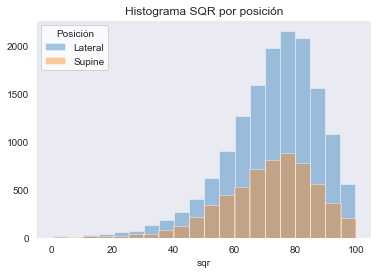

In [139]:
sns.distplot(perfiles_sqr.loc[perfiles_sqr['posicion']=="Lateral",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['posicion']=="Supine",'sqr'], bins=20,kde = False,hist=True).set_title('Histograma SQR por posición')
plt.legend(title='Posición', loc='upper left', labels=['Lateral', 'Supine'],facecolor = 'white')
plt.show()

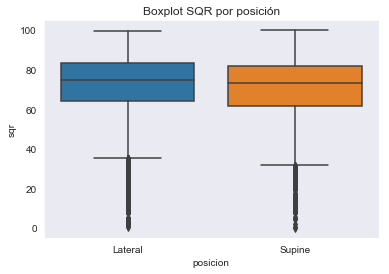

In [132]:
sns.boxplot(x="posicion", y="sqr",data=perfiles_sqr).set_title("Boxplot SQR por posición")
plt.show()

#### IMC con SQR

Las personas con sobrepeso tienen un SQR medio menor que el de las personas con peso normal y con peso bajo.

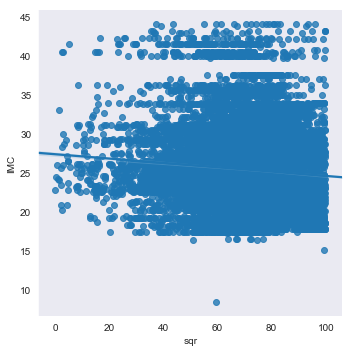

In [201]:
sns.lmplot(x="sqr", y="IMC", data=perfiles_sqr)
plt.show()

In [134]:
perfiles_sqr.groupby('IMC_cat').agg({'sqr': [min, max, 'mean', 'std', 'size'],})

sqr                                        
                min        max       mean        std   size
IMC_cat                                                    
Bajo peso  0.018056  99.859722  73.306604  15.053869  11805
Normal     0.627778  99.581944  71.194543  15.695081   6393
Sobrepeso  1.523611  99.581944  69.585994  15.752310   3021

In [ ]:
from scipy.stats import f_oneway
a = perfiles_sqr.loc[perfiles_sqr['IMC_cat']=="Bajo peso",'sqr']
b = perfiles_sqr.loc[perfiles_sqr['IMC_cat']=="Normal",'sqr']
c = perfiles_sqr.loc[perfiles_sqr['IMC_cat']=="Sobrepeso",'sqr']

In [ ]:
f_oneway(a,b,c)

In [ ]:
stats.kruskal(a,b,c)

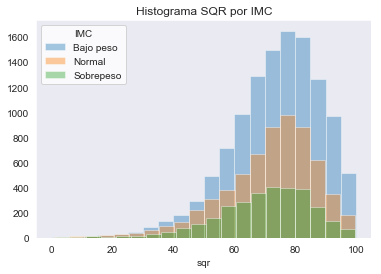

In [138]:
sns.distplot(perfiles_sqr.loc[perfiles_sqr['IMC_cat']=="Bajo peso",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['IMC_cat']=="Normal",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['IMC_cat']=="Sobrepeso",'sqr'], bins=20,kde = False,hist=True).set_title('Histograma SQR por IMC')
plt.legend(title='IMC', loc='upper left', labels=['Bajo peso', 'Normal', 'Sobrepeso'],facecolor = 'white')
plt.show()

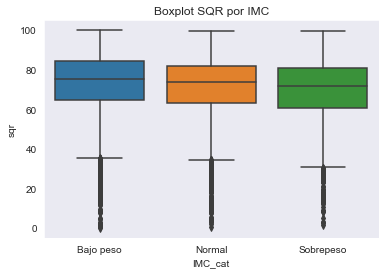

In [135]:
sns.boxplot(x="IMC_cat", y="sqr",data=perfiles_sqr).set_title("Boxplot SQR por IMC")
plt.show()

#### Tubos con SQR

A continuación se muestra la distribución del SQR en función de la presión utilizada en cada uno de los tubos. Nótese que las presiones 4 y 5 son las menos utilizadas y, por tanto, su tamaño muestral es menor. Esto puede causar que sean los histogramas más variables.

##### Tubo 1

In [141]:
perfiles_sqr.groupby('PresPos1').agg({'sqr': [min, max, 'mean', 'std', 'size'],})

sqr                                       
                min        max       mean        std  size
PresPos1                                                  
0          0.548611  99.720833  72.601943  15.090361  9684
1          0.018056  99.859722  71.755330  15.535917  8464
2          1.523611  99.581944  70.594354  16.243762  1791
3          5.200000  99.581944  74.177582  14.898699   628
4         35.393210  99.581944  75.105263  14.771614   100
5          7.991667  99.566667  72.115225  16.422189   552

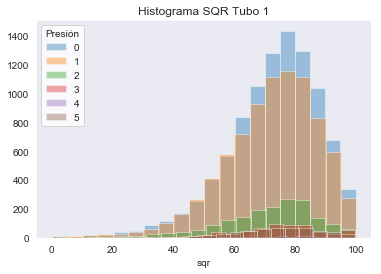

In [170]:
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="0",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="1",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="2",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="3",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="4",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="5",'sqr'], bins=20,kde = False,hist=True).set_title('Histograma SQR Tubo 1')
plt.legend(title='Presión', loc='upper left', labels=['0', '1', '2', '3','4','5'],facecolor = 'white')
plt.show()

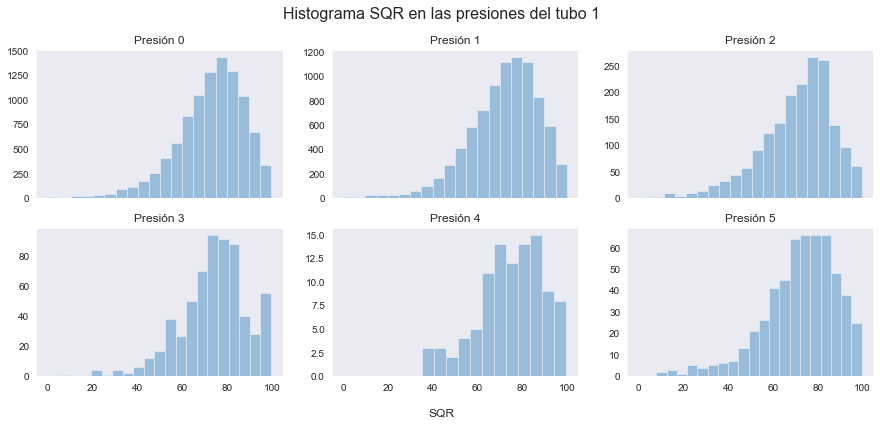

In [212]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=False,figsize = (15,6))
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="0",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 0]).set(title = 'Presión 0',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="1",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 1]).set(title = 'Presión 1',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="2",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 2]).set(title = 'Presión 2',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="3",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 0]).set(title = 'Presión 3',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="4",'sqr'], bins=12,kde = False,hist=True,ax=axs[1, 1]).set(title = 'Presión 4',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="5",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 2]).set(title = 'Presión 5',xlabel=None)
fig.text(0.5, 0.04, 'SQR', va='center', ha='center', fontsize=12)
fig.suptitle('Histograma SQR en las presiones del tubo 1', fontsize=16)
plt.show()

##### Tubo 2

In [161]:
perfiles_sqr.groupby('PresPos2').agg({'sqr': [min, max, 'mean', 'std', 'size'],})

sqr                                        
                min        max       mean        std   size
PresPos2                                                   
0          2.769516  99.581944  73.104625  15.845595    730
1          2.319444  99.581944  71.578082  15.690513   3405
2          0.018056  99.859722  72.570181  15.138626  13663
3          1.523611  99.581944  68.869956  15.906255   2664
4         23.835269  99.581944  81.920981  13.345318    297
5          7.991667  99.566667  74.639649  14.596860    460

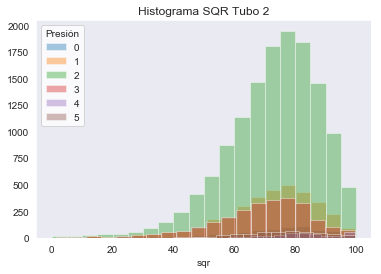

In [171]:
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="0",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="1",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="2",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="3",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="4",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="5",'sqr'], bins=20,kde = False,hist=True).set_title('Histograma SQR Tubo 2')
plt.legend(title='Presión', loc='upper left', labels=['0', '1', '2', '3','4','5'],facecolor = 'white')
plt.show()

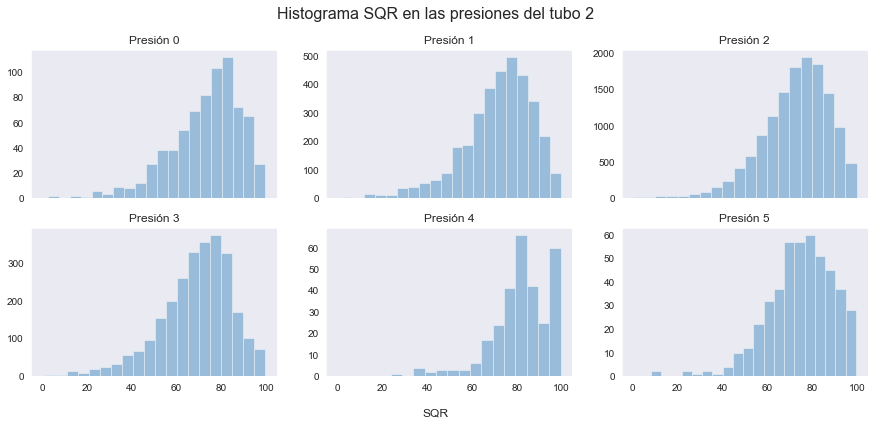

In [214]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=False,figsize = (15,6))
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="0",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 0]).set(title = 'Presión 0',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="1",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 1]).set(title = 'Presión 1',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="2",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 2]).set(title = 'Presión 2',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="3",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 0]).set(title = 'Presión 3',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="4",'sqr'], bins=15,kde = False,hist=True,ax=axs[1, 1]).set(title = 'Presión 4',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="5",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 2]).set(title = 'Presión 5',xlabel=None)
fig.text(0.5, 0.04, 'SQR', va='center', ha='center', fontsize=12)
fig.suptitle('Histograma SQR en las presiones del tubo 2', fontsize=16)
plt.show()

##### Tubo 3

In [164]:
perfiles_sqr.groupby('PresPos3').agg({'sqr': [min, max, 'mean', 'std', 'size'],})

sqr                                        
                min        max       mean        std   size
PresPos3                                                   
0          2.769516  99.581944  72.882226  14.659433    740
1          2.743056  99.336111  66.478631  20.167444    459
2          0.018056  99.859722  71.739676  15.234670  11673
3          1.523611  99.581944  73.004088  15.177913   6987
4         12.990278  99.581944  73.607598  16.194871    775
5          5.200000  99.566667  71.386737  16.014291    585

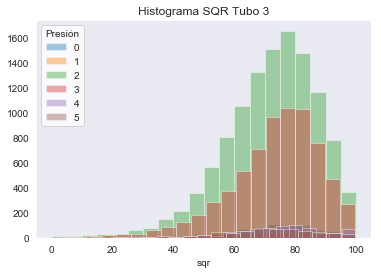

In [172]:
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="0",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="1",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="2",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="3",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="4",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="5",'sqr'], bins=20,kde = False,hist=True).set_title('Histograma SQR Tubo 3')
plt.legend(title='Presión', loc='upper left', labels=['0', '1', '2', '3','4','5'],facecolor = 'white')
plt.show()

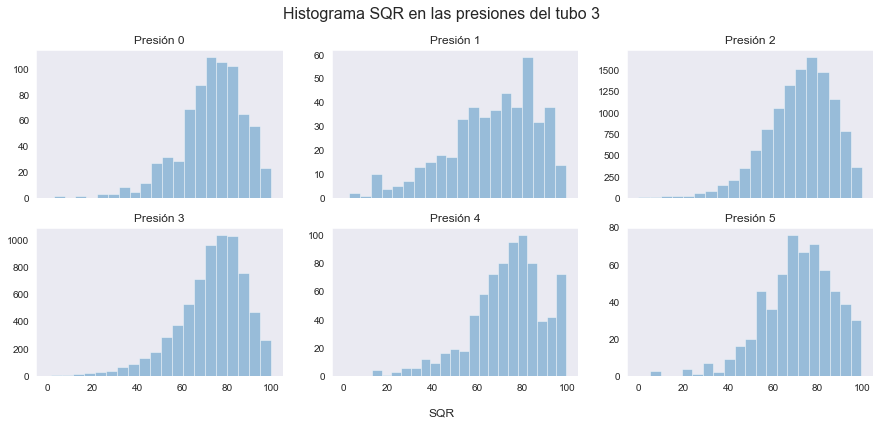

In [166]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=False,figsize = (15,6))
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="0",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 0]).set(title = 'Presión 0',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="1",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 1]).set(title = 'Presión 1',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="2",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 2]).set(title = 'Presión 2',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="3",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 0]).set(title = 'Presión 3',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="4",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 1]).set(title = 'Presión 4',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="5",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 2]).set(title = 'Presión 5',xlabel=None)
fig.text(0.5, 0.04, 'SQR', va='center', ha='center', fontsize=12)
fig.suptitle('Histograma SQR en las presiones del tubo 3', fontsize=16)
plt.show()

##### Tubo 4

In [167]:
perfiles_sqr.groupby('PresPos4').agg({'sqr': [min, max, 'mean', 'std', 'size'],})

sqr                                       
                min        max       mean        std  size
PresPos4                                                  
0          2.769516  99.581944  73.149089  14.962538   808
1          2.743056  99.581944  72.010057  16.836826  1441
2          0.018056  99.859722  72.424461  14.808427  7570
3          0.548611  99.720833  72.310961  15.581258  9751
4         12.947659  99.581944  68.393368  15.656627  1072
5          5.200000  99.566667  71.411545  15.869846   577

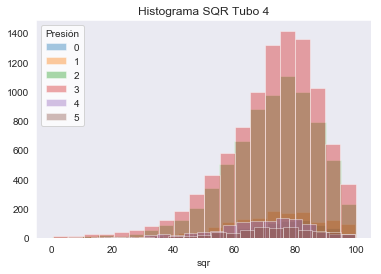

In [173]:
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="0",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="1",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="2",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="3",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="4",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="5",'sqr'], bins=20,kde = False,hist=True).set_title('Histograma SQR Tubo 4')
plt.legend(title='Presión', loc='upper left', labels=['0', '1', '2', '3','4','5'],facecolor = 'white')
plt.show()

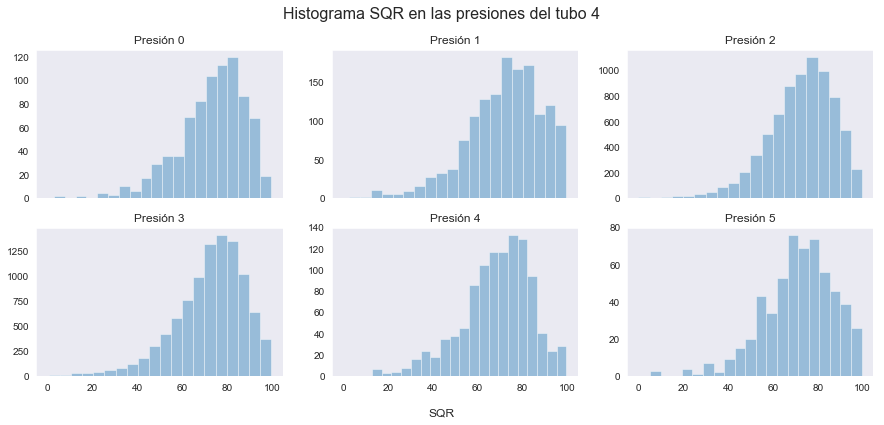

In [169]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=False,figsize = (15,6))
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="0",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 0]).set(title = 'Presión 0',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="1",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 1]).set(title = 'Presión 1',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="2",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 2]).set(title = 'Presión 2',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="3",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 0]).set(title = 'Presión 3',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="4",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 1]).set(title = 'Presión 4',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="5",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 2]).set(title = 'Presión 5',xlabel=None)
fig.text(0.5, 0.04, 'SQR', va='center', ha='center', fontsize=12)
fig.suptitle('Histograma SQR en las presiones del tubo 4', fontsize=16)
plt.show()

##### Tubo 5

In [174]:
perfiles_sqr.groupby('PresPos5').agg({'sqr': [min, max, 'mean', 'std', 'size'],})

sqr                                       
               min        max       mean        std  size
PresPos5                                                 
0         2.769516  99.581944  74.623691  15.425138   665
1         0.018056  99.581944  72.362595  15.032707  4687
2         0.548611  99.720833  73.071392  14.229057  7630
3         0.627778  99.859722  71.419228  16.408467  6772
4         1.523611  99.559722  66.341276  17.010318   824
5         7.991667  99.581944  71.936466  16.561297   641

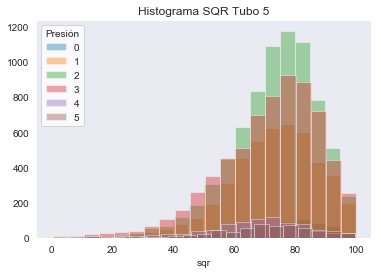

In [175]:
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="0",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="1",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="2",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="3",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="4",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="5",'sqr'], bins=20,kde = False,hist=True).set_title('Histograma SQR Tubo 5')
plt.legend(title='Presión', loc='upper left', labels=['0', '1', '2', '3','4','5'],facecolor = 'white')
plt.show()

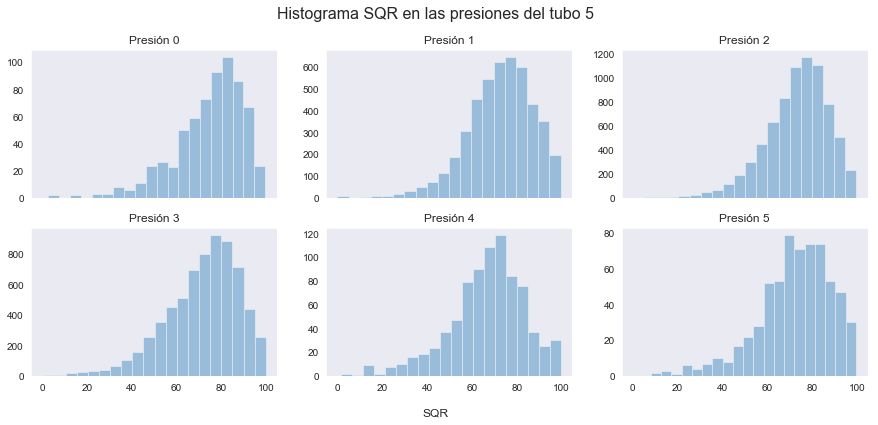

In [176]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=False,figsize = (15,6))
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="0",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 0]).set(title = 'Presión 0',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="1",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 1]).set(title = 'Presión 1',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="2",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 2]).set(title = 'Presión 2',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="3",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 0]).set(title = 'Presión 3',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="4",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 1]).set(title = 'Presión 4',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="5",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 2]).set(title = 'Presión 5',xlabel=None)
fig.text(0.5, 0.04, 'SQR', va='center', ha='center', fontsize=12)
fig.suptitle('Histograma SQR en las presiones del tubo 5', fontsize=16)
plt.show()

##### Tubo 6

In [178]:
perfiles_sqr.groupby('PresPos6').agg({'sqr': [min, max, 'mean', 'std', 'size'],})

sqr                                       
                min        max       mean        std  size
PresPos6                                                  
0          2.769516  99.581944  74.072956  14.524366   885
1          0.548611  99.720833  72.439487  14.311262  8929
2          0.018056  99.859722  71.769776  16.267688  8341
3          1.523611  99.581944  70.900409  16.757019  2425
4         40.709470  99.559722  74.601636  11.407603   177
5          7.991667  99.581944  74.922135  14.811317   462

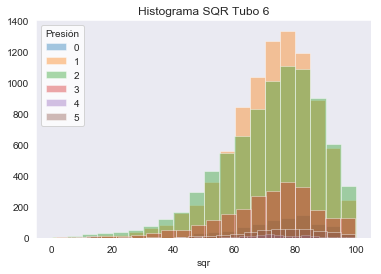

In [179]:
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="0",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="1",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="2",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="3",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="4",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="5",'sqr'], bins=20,kde = False,hist=True).set_title('Histograma SQR Tubo 6')
plt.legend(title='Presión', loc='upper left', labels=['0', '1', '2', '3','4','5'],facecolor = 'white')
plt.show()

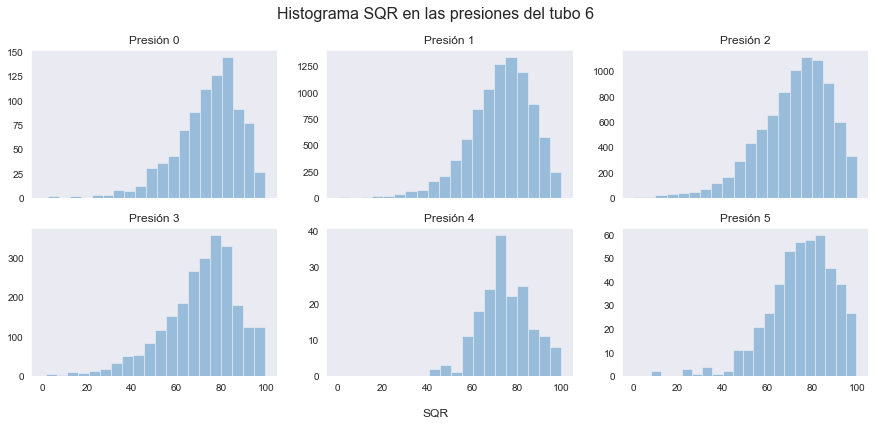

In [210]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=False,figsize = (15,6))
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="0",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 0]).set(title = 'Presión 0',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="1",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 1]).set(title = 'Presión 1',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="2",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 2]).set(title = 'Presión 2',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="3",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 0]).set(title = 'Presión 3',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="4",'sqr'], bins=12,kde = False,hist=True,ax=axs[1, 1]).set(title = 'Presión 4',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="5",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 2]).set(title = 'Presión 5',xlabel=None)
fig.text(0.5, 0.04, 'SQR', va='center', ha='center', fontsize=12)
fig.suptitle('Histograma SQR en las presiones del tubo 6', fontsize=16)
plt.show()

##### Todos los tubos

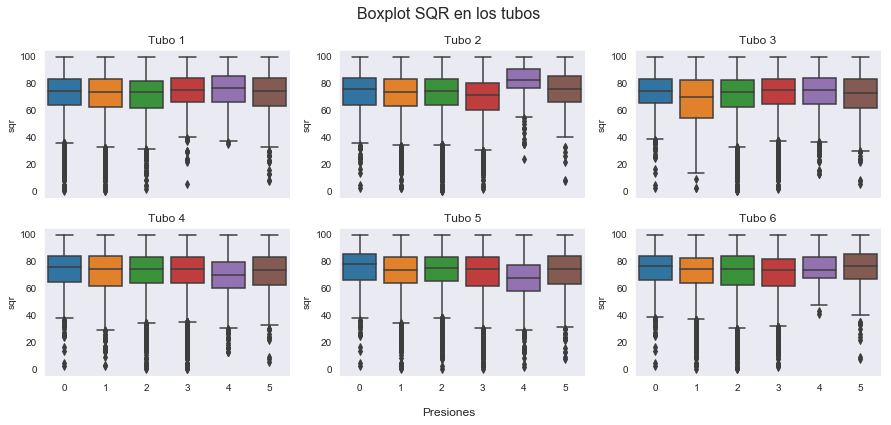

In [160]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=False,figsize = (15,6))
sns.boxplot(x="PresPos1", y="sqr",data=perfiles_sqr,ax=axs[0, 0]).set(title = 'Tubo 1',xlabel=None)
sns.boxplot(x="PresPos2", y="sqr",data=perfiles_sqr,ax=axs[0, 1]).set(title = 'Tubo 2',xlabel=None)
sns.boxplot(x="PresPos3", y="sqr",data=perfiles_sqr,ax=axs[0, 2]).set(title = 'Tubo 3',xlabel=None)
sns.boxplot(x="PresPos4", y="sqr",data=perfiles_sqr,ax=axs[1, 0]).set(title = 'Tubo 4',xlabel=None)
sns.boxplot(x="PresPos5", y="sqr",data=perfiles_sqr,ax=axs[1, 1]).set(title = 'Tubo 5',xlabel=None)
sns.boxplot(x="PresPos6", y="sqr",data=perfiles_sqr,ax=axs[1, 2]).set(title = 'Tubo 6',xlabel=None)
fig.text(0.5, 0.04, 'Presiones', va='center', ha='center', fontsize=12)
fig.suptitle('Boxplot SQR en los tubos', fontsize=16)
plt.show()